Import all necessary modules

In [53]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import csv

Function Dictionary

In [54]:
# Calculate E(z)
def E(z_i, omega_m, omega_l):
    omega_k = 1.0 - omega_m - omega_l
    E = np.sqrt(omega_m * (1.0 + z_i)**3 + omega_k * (1.0 + z_i)**2 + omega_l)
    return E;

# Calculate the integral D_C/D_H, store it in an array
def DCDH_int(z_limit, omega_m, omega_l):
    f = lambda z_i: 1.0 / E(z_i, omega_m, omega_l)
    i = integrate.quad(f, 0, z_limit)
    return i[0]

In [55]:
# Proper Motion distance integrals

# proper motion distance for omega_l == 0
def prop_motion_0(z, DMDH, omega_m, omega_l):
    # create the output array DMDH
    DMDH = np.copy(z);

    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    print(r"$\Omega_k =$ " + str(omega_k))
    print(r"$\Omega_\Mu =$ " + str(omega_m))
    print(r"$\Omega_\Lambda =$ " + str(omega_l))

    # Calculate D_M/D_H for different universe geometries
    # open universe
    if (omega_k > 1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z[i],omega_m,omega_l) )
    # closed universe
    elif (omega_k < -1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z[i],omega_m,omega_l) )
    # flat universe
    else:
        DMDH = 2.0*( 2.0 - omega_m*(1.0-z) - (2-omega_m)*np.sqrt(1.0+omega_m*z) ) / ( omega_m*omega_m*(1.0+z) );

    return DMDH

# proper motion distance for omega_l != 0
def prop_motion(z, DMDH, omega_m, omega_l):
    DMDH = np.copy(z);
    
    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    print(omega_k)
    
    # Calculate D_M/D_H for different universe geometries
    if (omega_k > 1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z[i],omega_m,omega_l) )
    # closed universe
    elif (omega_k < -1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z[i],omega_m,omega_l) )
    # flat universe
    else:
        for i in range(len(z)):
            DMDH[i] = DCDH_int(z[i], omega_m, omega_l)
    return DMDH

In [56]:
# angular diameter distance
def dist_angdiam(z, DMDH, DADH, omega_m, omega_l):
    DADH = np.copy(z);
    DADH = DMDH / (1.0+z)
    return DADH;

# luminosity distance
def dist_lum(z, DMDH, DLDH, omega_m, omega_l):
    DLDH = np.copy(z)
    DLDH = DMDH * (1.0+z)
    return DLDH;

# distance modulus
def dist_mod(z, D_H, omega_m, omega_l, DMDH):
    # initialize the distance modulus array
    mu = np.copy(z)

    # convert D_H from Mpc to pc
    D_H = D_H * 1.0e6

    # calculate each value of mu array
    #for i in range(len(z)):
        #mu[i] = 5.0 * ( np.log10(1.0+z[i]) + np.log10(DCDH_int(z[i], omega_m, omega_l)) + np.log10(D_H/10) )
    mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
    return mu;

# comoving volume element
def com_vol(z, DMDH, DVC, omega_m, omega_l, D_H):
    DVC = np.copy(z)
    for i in range(len(z)):
        DVC[i] = DMDH[i]**2 * D_H**3 / ( E(z[i], omega_m, omega_l) )
    return DVC;

Variable Dictionary

In [69]:
# Constants
omega_k = 0                     # critical density
c = 2.9979e5                    # speed of light (km/s)
omega_m = None                  # mass density parameter
w = None                        # equation of state
omega_l = None                  # energy density
pressure = 0.0                  # pressure of the universe

# Variable dictionary
H = None                        # Hubble constant (km/s/Mpc)
z = None                        # redshift
D_C = None                      # comoving distance, line-of-sight (m)
D_M = None                      # comoving distance, transverse (m)
D_A = None                      # angular diameter distance (m)
D_L = None                      # luminosity distance (m)
V_C = None                      # comoving volume (m^3)
D_H = None                      # Hubble Distance (Mpc)
array_size = None               # size of each array, which is the number of z values
param_text = ""                 # label for the plots

# Output arrays
z = None;                       # Array of input values of z
DMDH = np.array([])             # Array of output values of D_M/D_H
DADH = np.array([])             # Array of output values of D_A/D_H
DLDH = np.array([])             # Array of output values of D_L/D_H
dmod = np.array([])             # distance modulus array
DVC = np.array([])              # comoving volume array
tLtH = np.array([])             # Array of lookback times
age = np.array([])              # Array of ages
dPdz = np.array([])             # dimensionless intersection probability

We draw arrays of corresponding density parameters from Figure 20.

We note that equation of state $w$ and energy density $\Omega_\Lambda$ are related as follows:
$$w = \frac{pressure}{\Omega_\Lambda}$$

In [70]:
# arrays of density parameters
omegam_array = np.array([1.0, 0.05, 0.2])
w_array = np.array([0.0, 0.0, 0.8])
omegal_array = np.copy(w_array)
omegal_array = pressure / w_array

# Note: remove this later
# arrays of density parameters
omegam_array = np.array([1.0, 0.05, 0.2])
omegal_array = np.array([0.0, 0.0, 0.8])

<ipython-input-70-6fd72f42069d>:5: RuntimeWarning: invalid value encountered in true_divide
  omegal_array = pressure / w_array


Take in values

In [71]:
# Take in densities
print("\u03A9_k = 0.0")     # omega_k = 0.0

# Take in Hubble constant
H = 70#float(input("Enter Hubble constant (in km/s/Mpc): "))
D_H = c / H                 # Hubble distance

# Parameters for plot, including the range of redshift values and y-axis
zmin = 0
zmax = 5
ymin = 0
ymax = None

# Define the array of z-values (redshift)
z = np.linspace(zmin, zmax, 100)
print("z values:")
print(z)

Ω_k = 0.0
z values:
[0.         0.05050505 0.1010101  0.15151515 0.2020202  0.25252525
 0.3030303  0.35353535 0.4040404  0.45454545 0.50505051 0.55555556
 0.60606061 0.65656566 0.70707071 0.75757576 0.80808081 0.85858586
 0.90909091 0.95959596 1.01010101 1.06060606 1.11111111 1.16161616
 1.21212121 1.26262626 1.31313131 1.36363636 1.41414141 1.46464646
 1.51515152 1.56565657 1.61616162 1.66666667 1.71717172 1.76767677
 1.81818182 1.86868687 1.91919192 1.96969697 2.02020202 2.07070707
 2.12121212 2.17171717 2.22222222 2.27272727 2.32323232 2.37373737
 2.42424242 2.47474747 2.52525253 2.57575758 2.62626263 2.67676768
 2.72727273 2.77777778 2.82828283 2.87878788 2.92929293 2.97979798
 3.03030303 3.08080808 3.13131313 3.18181818 3.23232323 3.28282828
 3.33333333 3.38383838 3.43434343 3.48484848 3.53535354 3.58585859
 3.63636364 3.68686869 3.73737374 3.78787879 3.83838384 3.88888889
 3.93939394 3.98989899 4.04040404 4.09090909 4.14141414 4.19191919
 4.24242424 4.29292929 4.34343434 4.393939

Plot the Distance Modulus

Distance Modulus vs Redshift
$\Omega_k =$ 0.0
$\Omega_\Mu =$ 1.0
$\Omega_\Lambda =$ 0.0
i = 0
distance molulus DM + 5 log h
$\Omega_k =$ 0.95
$\Omega_\Mu =$ 0.05
$\Omega_\Lambda =$ 0.0
i = 1
distance molulus DM + 5 log h
0.0
i = 2
distance molulus DM + 5 log h


<ipython-input-56-a499bbc14b13>:24: RuntimeWarning: divide by zero encountered in log10
  mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
<ipython-input-56-a499bbc14b13>:24: RuntimeWarning: divide by zero encountered in log10
  mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
<ipython-input-56-a499bbc14b13>:24: RuntimeWarning: divide by zero encountered in log10
  mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
<ipython-input-75-697af3914e33>:26: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.axis([zmin, zmax, ymin, ymax]);


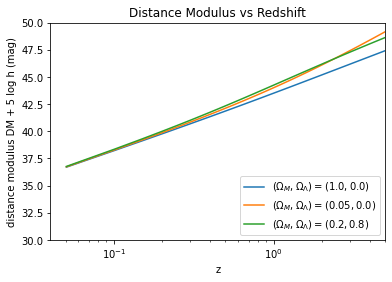

In [75]:
print("Distance Modulus vs Redshift");
plt.title("Distance Modulus vs Redshift");
plt.xlabel("z");
plt.ylabel("distance modulus DM + 5 log h (mag)");

ymin = 30
ymax = 50

for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]
    if (omega_l == 0):
        DMDH = prop_motion_0(z, DMDH, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, DMDH, omega_m, omega_l)
        
    mu = dist_mod(z, D_H, omega_m, omega_l, DMDH)
    print("i = " + str(i))
    print("distance molulus DM + 5 log h")
    #print(mu)
    
    param_text = r"$\left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, mu, label=param_text)
    plt.xscale('log')

plt.axis([zmin, zmax, ymin, ymax]);
plt.legend(loc='lower right');
plt.show()

Generate a scatter plot of supernovae

First, generate lists of data from the CSV file "ps1_data.txt":

sne_x
[0.50309, 0.4948, 0.67767, 0.8665, 0.79857, 0.37144, 0.35582, 0.2836, 0.4664, 0.94688, 0.69315, 0.89693, 0.78904, 0.59027, 0.21075, 0.85852, 0.55875, 0.9964, 0.58294, 0.79656, 0.91348, 0.94846, 0.73362, 0.7656, 0.98341, 0.70064, 0.83814, 0.3706, 0.35858, 0.52278, 0.70198, 0.74613, 0.59185, 0.62063, 1.00279, 0.61064, 0.35833, 0.45155, 0.5526, 0.75068, 0.82269, 0.95076, 0.34052, 0.81072, 0.61124, 0.54831, 1.02879, 0.42244, 0.70115, 0.68517, 0.93189, 0.74909, 0.4684, 0.95886, 0.84053, 0.56276, 0.82854, 0.57875, 0.8645, 0.85851, 0.58575, 0.48881, 0.68866, 0.32454, 0.18538, 0.68196, 0.92223, 0.42866, 0.69998, 0.57584, 0.51176, 0.64191, 0.35157, 0.34957, 0.35527, 0.87217, 0.92624, 0.41957, 0.89073, 0.48057, 0.5806, 0.80569, 0.66464, 0.74566, 0.73669, 0.37053, 0.85073, 0.21946, 0.64764, 0.6006, 0.7607, 0.47057, 0.49737, 0.50736, 0.58728, 0.69915, 0.76108, 0.78805, 0.40547, 0.80804, 0.58328, 0.72013, 0.83699, 0.80603, 0.50074, 0.53378, 0.82212, 0.12531, 0.44368, 0.68366, 0.72668, 0.40455

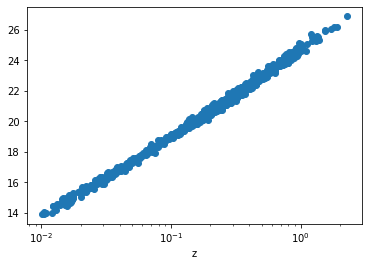

In [77]:
sne_x = []
sne_y = []

with open('ps1_data.txt', newline='') as csvfile:
    ps1_data = csv.reader(csvfile, delimiter=' ')
        
    i = 0
    for row in ps1_data:
        if (i > 0):
            sne_x.append(float(row[1]))
            sne_y.append(float(row[4]))
        i+= 1
        
print("sne_x")
print(sne_x)
print("sne_y")
print(sne_y)
plt.xlabel("z")
plt.scatter(sne_x, sne_y)
plt.xscale('log')
plt.show()